# MICQP-based planning for a Multirotor 

Authors: Alan Papalia, Andrew Torgesen, Andrea Tagliabue 

* * *
**Sources:**
- https://en.wikipedia.org/wiki/Trajectory_optimization
- https://en.wikibooks.org/wiki/Convexity/What_is_a_convex_set%3F
- https://en.wikipedia.org/wiki/Linear_programming
- https://en.wikipedia.org/wiki/Convex_optimization
- https://en.wikipedia.org/wiki/Quadratically_constrained_quadratic_program
- https://support.sas.com/rnd/app/or/procedures/milp.html

* * *
**Table of Contents:**

I [Trajectory Optimization Background](#background)

I-A [Introduction to Trajectory Optimization](#trajgen_intro)

I-B [Introduction to Convex Optimization](#convex_intro)

II [Case Study: Planar VTOL](#case_study)

II-A [System Definition](#sys_def)
    
II-B [MIQCP Encoding](#encoding)
   
III [Case Study Solution](#solution)

III-A [Methods for Solving Convex Programs](#conv_method)
    
III-B [Obstacle-Avoiding VTOL Trajectory](#vtol_traj)
    
* * *

## <a name="background"></a>I Trajectory Optimization Background

### <a name="trajgen_intro"></a>I-A Introduction to Trajectory Optimization

The objective of trajectory optimization is to generate, given an initial state and desired final goal state, a time-parametrized path (or trajectory) which minimizes a given performance metric (or cost function) while simultaneously satisfying a set of constraints. This problem is closely related to solving an open-loop optimal control problem. Moreover, it is usually considered a local planning problem because the goal is to generate a trajectory which terminates a few meters away from the current position of the robot, successively updating the termination point as the robot moves.

Common examples of cost functions for trajectory generation in robotics are:
- the energy required to follow the trajectory
- the control effort (often related to energy) required
- the average or maximum acceleration/jerk/snap 
- the time to execute the trajectory.

In robotics applications, the trajectory optimization output is usually fed as a motion control command for a robot, and thus has to satisfy strict requirements in terms of dynamic feasibility, smoothness, efficient re-computability, etc.

Common examples of constraints for trajectory generation in robotics are:
- constraints from the environment such as obstacles (static or dynamic) that must be avoided
- constraints on the performance of the system, such as the maximum control effort or saturations on the actuators of the robot
- the final time and final state of the robot (e.g. when trying to intercept a moving object)
- kinematic and dynamic constraints (e.g. a car cannot move sideways or a quadcopter cannot accelerate horizontally without pitching or rolling).

#### Mathematical Formulation
The Trajectory optimization problem can be mathematically formulated as follows:
$$\min_{p} J(p)$$ $$ \text{s.t.} \\ p \in P$$

where $J(\cdot)$ is the objective function, $p$ represents time-parameterized path found by the trajectory generator, and $P$ is the set of state trajectories that satisfies all given constraints. 

#### Solution Techniques
The typical techniques used to solve a trajectory optimization problem can be grouped in two cathegories:
1. **Direct method:** iteratively construct a numerical approximation to the solution to the problem. 
2. **Indirect method:** analytically construct the direct and sufficent conditions for optimality, which are then solved numerically.

#### Time Encoding
Time for trajectory generation is generally handled in one of two ways:

1. **fixed arrival time**
2. **receding horizon**

In the first case, all the trajectories $p \in P$ have to satisfy the additional constraint that the final state of the robot (position, velocity etc..) must be reached at the given time $T$.  In the second case, the trajectory is iteratively re-planned for a given, small time horizon. At every time step, the planner updates the current trajectory by re-planning a new trajectory with the final time increased one step from the previous final time. 

While the fixed arrival time approach has the advantage of minimizing the cost function along the entire trajectory, the receding horizon approach--despite offering a sub-optimal result--is less computationally expensive.

### <a name="convex_intro"></a>I-B Introduction to Convex Optimization

#### Convex Functions and Sets

A convex function can be formally defined as follows:

\begin{equation*}
\text{for any x,y for which the function, f(*), exists and 0 $\leq$ a $\leq$ 1} \\
f(ax + (1-a)y) \leq af(x)+(1-a)f(y) \\
\end{equation*}

This can be easily visualized in the following diagram:

<img src="convexfunction.png" style="width:70%;"/>


By <a href="//commons.wikimedia.org/w/index.php?title=User:Eli_Osherovich&amp;action=edit&amp;redlink=1" class="new" title="User:Eli Osherovich (page does not exist)">Eli Osherovich</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=10764763">Link</a>

Likewise, a convex set is defined as a set where for any two points $(x_1, x_2)$ within the set, every point on the line that connects those points will also lie within the set. More formally, if $X$ is a convex set and $ x_1 \cdots x_n $ are points in the set, then:

\begin{equation*}
x = \sum_{k=1}^n x_k\lambda_k  \text{ where } \lambda_k > 0 \text{ and }  \sum_{k=1}^n \lambda_k = 1
\end{equation*}

The image below gives good intuition for convexity of a set.

<img src="diagonals.png" style="width:30%;"/>
By <a href="//commons.wikimedia.org/wiki/User:Dbc334" title="User:Dbc334">Dbc334</a> - Drawn by me, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=1678436">Link</a>

Convexity has huge implications for optimization, and much work has been put into techniques for solving convex problems as well as techniques to restructure non-convex problems into convex ones. 

#### Convex Optimization

A convex optimization problem is an optimization problem in which the objective function is a convex function and the feasible set is a convex set. It can be formulated as:
$$\displaystyle \min_{x} f(x)$$
$$\text{subject to} \\ g_i(x) \leq 0, \ i=1, ..., m$$
$$\\ h_i(x) \leq 0, \ i=1, ..., p$$
where $f, g_1, \cdots, g_m$ are convex and $h_1, \cdots, h_p$ are affine constraints. It should be noted that affine constraints are indeed convex, but they are listed separately in this formulation for convenience. 

A convex optimization problem has the following properties:
- every local minimum is a global minimum
- the optimal set is convex
- if the objective function is *strictly* convex, then the problem has at most one optimal point.

The following are examples of convex optimization problems that are commonly encountered:

- **Linear Programming:** In linear programming, an optimization problem is characterized by a linear cost function, a linear set of inequality constraints, and non-negative variables. Geometrically, the inequlity constraints, which define the feasible region, describe a convex polyhedron. The linear objective function is a convex function, which implies that every local minimum is a global minimum. A solution is guaranteed to exist under the assumptions that the problem is feasible (e.g. having a non-empty feasible space) and that the problem is not unbounded. A linear program can be expressed mathematically as 

$$\displaystyle \max_{x} c^Tx$$
$$ \text{subject to} \\ Ax\leq b \\x \geq 0. $$ 

- **Mixed-Integer Linear Program:** A linear problem is said to be integral if it has at least one optimal solution which is integral. This means that the domain of some of the optimization variables $x$ is defined on $\mathbb{Z}$.
- **Quadratic Program:** A quadratic program is an optimization problem where the cost function is quadratic. A quadratic cost function has the form:

$$f(x)=\frac{1}{2}x^TQx + c^Tx$$

- **Quadratically Constrained Quadratic Program (QCQP):** If a quadratic program has constraints expressed in quadratic form (which can exist alongside linear or affine constraints such as $Ax = b$), then the problem is said to be quadratically constrained. Quadratic constraints can be expressed as:

$$g_i(x) = \frac{1}{2}x^TP_ix + q_i^Tx + r_i \leq 0 \\ \text{for} \ i = 1, ..., m$$

- **Mixed Integer Quadratically Constrained Program (MIQCP):** If a program has any quadratic constraint, as well as any design variable defined on $\mathbb{Z}$, then it is termed a MIQCP.

## <a name="case_study"></a> II Case Study: Planar VTOL

This project aims to cast a case study system as an MIQCP trajectory optimization problem. The following sections describe the case study system and provide a corresponding MIQCP formulation.

### <a name="sys_def"></a> II-A System Definition

The dynamic system in question is a vertical takeoff and landing (VTOL) unmanned air vehicle (UAV) that is confined to the plane. Below is a diagram illustrating the system and its state variables:

![](VTOL.svg)

The equations of motion that govern the system can be expressed as

$$(m_c+m_r+m_l)\ddot{z}=-(F_l+F_r)\sin \theta$$

$$(m_c+m_r+m_l)\ddot{h}+g(m_c+m_r+m_l)=(F_l+F_r)\cos \theta$$

$$(m_l d^2+m_r d^2+J_c)\ddot{\theta}+(m_r-m_l)gd\cos \theta=(F_r-F_l)d$$

where $z$ is the horizontal coordinate of the VTOL, $\theta$ is the clockwise deviation of the right rotor from the horizontal, $h$ is the VTOL altitude, $F_l$ and $F_r$ are the left and right rotor thrusts, and with the parameter definitions:

| Variable | Explanation            | Value        |
|----------|------------------------|--------------|
| $m_c$      | Mass of VTOL body      | 1 $kg$         |
| $m_l$      | Mass of left rotor     | 0.25 $kg$      |
| $m_r$      | Mass of right rotor    | 0.25 $kg$      |
| $J_c$      | VTOL Moment of inertia | 0.0042 $kg~m^2$ |
| $d$        | Rotor arm length       | 0.3 $m$        |
| $\mu$      | Air drag term          | 0.1 $kg/s$     |
| $g$        | Gravity                | 9.81 $m/s^2$   |

For the purpose of trajectory generation, a simplified model of the system is derived by linearizing the dynamics about the current point in the trajectory (denoted by the $\bar{\cdot}$ symbol), giving the following state-space model:

$$\dot{x}=\begin{bmatrix}0 & 1 & 0 & 0 & 0 & 0 \\
                         0 & \frac{-\mu}{m_l+m_r+m_c} & \frac{-\bar{F}\cos\bar{\theta}}{m_l+m_r+m_c} & 0 & 0 & 0\\
                         0 & 0 & 0 & 1 & 0 & 0\\
                         0 & 0 & 0 & 0 & 0 & 0\\
                         0 & 0 & 0 & 0 & 0 & 1\\
                         0 & 0 & \frac{-\bar{F}\sin\bar{\theta}}{m_l+m_r+m_c} & 0 & 0 & 0\end{bmatrix}x + \begin{bmatrix}0 & 0\\
               \frac{-\sin\bar{\theta}}{m_l+m_r+m_c} & 0\\
               0 & 0\\
               0 & \frac{1}{m_ld^2+m_rd^2+J_c}\\
               0 & 0\\
               \frac{\cos\bar{\theta}}{m_l+m_r+m_c}\end{bmatrix}u$$

where $x=\begin{bmatrix}z&\dot{z}&\theta&\dot{\theta}&h&\dot{h}\end{bmatrix}^T$, $u=\begin{bmatrix}F&\tau\end{bmatrix}^T$, $F \triangleq f_r+f_l$ is the thrust, and $\tau \triangleq d(f_r-f_l)$ is the torque. It can be seen by inspection that the linearization of the dynamics is a function of the current thrust and orientation angle.

The above state space model is expressed in continuous time, and should be re-expressed in terms of discrete time. The relationship between a discrete state space model $A$, $B$ and its corresponding continuous state space model $A_c$, $B_c$ is given by

$$A=e^{A_c\Delta t},$$
$$B=(A_c)^{-1}(A_c-I)B_c.$$

A first-order approximation of the matrix exponential, $e^{A_c\Delta t}\approx I + A_c \Delta t$, will be used to obtain the discrete-time state space model:

$$A=\begin{bmatrix}1 & \Delta t & 0 & 0 & 0 & 0 \\
                   0 & 1 - \frac{\mu}{m_l+m_r+m_c}\Delta t & \frac{-\bar{F}\cos\bar{\theta}}{m_l+m_r+m_c}\Delta t & 0 & 0 & 0\\
                   0 & 0 & 1 & \Delta t & 0 & 0\\
                   0 & 0 & 0 & 1 & 0 & 0\\
                   0 & 0 & 0 & 0 & 1 & \Delta t\\
                   0 & 0 & 1 - \frac{\bar{F}\sin\bar{\theta}}{m_l+m_r+m_c}\Delta t & 0 & 0 & 1\end{bmatrix}$$

$$B=\begin{bmatrix}0 & 0\\
                   \frac{-\sin\bar{\theta}}{m_l+m_r+m_c}\Delta t & 0\\
                   0 & 0\\
                   0 & \frac{1}{m_ld^2+m_rd^2+J_c}\Delta t\\
                   0 & 0\\
                   \frac{\cos\bar{\theta}}{m_l+m_r+m_c}\Delta t\end{bmatrix}$$

A simulation of the VTOL system given naive, open-loop inputs can be found in the following two cells.

In [3]:
import vtolParam as P
from vtolAnimation import vtolAnimation
from vtolDynamics import vtolDynamics
from vtolObstacles import vtolObstacles
from IPython.display import HTML
from math import sin, pi
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

<IPython.core.display.Javascript object>


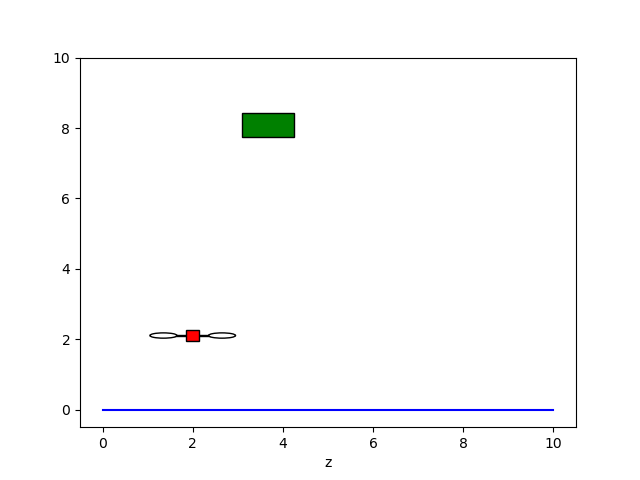

In [2]:
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

n = int((P.tf-P.t0)/P.Ts)
int((P.tf-P.t0)/P.Ts)
def getTime(i):
    return P.t0 + i * P.Ts

# Get inputs to system (will come from optimization)
inputs = list()
for i in range(0, n):
    t = getTime(i)
    F = P.Fe
    T = 0.0
    if t < 5:
        F += 0.1
    else:
        T += 0.1
    inputs.append([F, T])

# Obstacle Definitions
# list of ((x_min, y_min),(x_max, y_max)) tuple pairs
obstacles = list()
obstacleGenerator = vtolObstacles(P)
obstacles.append(obstacleGenerator.get_new_random())
    
# Simulation + Animation
vtol = None
animation = vtolAnimation()
animation.addObstacles(obstacles)
def animate(i):
    global vtol
    if i == 0:
        vtol = vtolDynamics()
    vtol.propagateDynamics(inputs[i])
    animation.drawVtol(vtol.outputs())
ani = matplotlib.animation.FuncAnimation(animation.fig, animate, n, interval=1000*P.Ts)

### <a name="encoding"></a>II-B MIQCP Encoding

A scenario where the above VTOL has to navigate around obstacles to reach a desired position can be formulated as an MIQCP problem. For the simplified real-world problem of trajectory planning for the VTOL, the associated constraints include the following:

- a maximum speed on the vehicle
- fixed start and end locations
- a need to avoid static objects

Because of the need to avoid objects, the problem formulation requires the use of mixed integers to maintain the convexity of the problem space. Time will be encoded in a receding horizon fashion.

For the encoding, we define the following given parameters for each iteration of the receding horizon optimization:

| Variable | Explanation            |
|----------|------------------------|
| $\hat{x}_g$      | Goal state      |
| $\hat{T}_\text{hor}$      | Receding horizon time     |
| $\hat{v}_\text{max}$      | Maximum VTOL velocity    |
| $\hat{x}_0$      | VTOL initial state |
| $\hat{u}_0$        | VTOL initial input       |
| $\hat{t}_0$      | Start time          |
| $\hat{u}_\text{max}$        | Input saturation limit                |

The following sections detail the various aspects of the MIQCP encoding of the problem.

#### Receding Horizon Formulation
Given the sampling time $\Delta t$, the number of discrete steps $N$ in the planning horizon is obtained as:
$$N = \frac{\hat{T}_\text{hor}}{\Delta t}$$
During a planning horizon, the discretized state and input vectors at the discrete time-step $k$, given the sampling time $\Delta t$, are: 
$$x_k = x(\hat{t}_0 + k\Delta t)$$
$$u_k = u(\hat{t}_0 + k\Delta t)$$

#### Objective Function
The objective function could look to minimize *fuel used, travel time, a combination of the two, or even a range of other functions*. 

###### For Fixed Arrival Time Formulation
The minimum control effort cost function (which is related to minimizing the energy used by the VTOL, since the square of the thrust force produced by the propellers is roughly proportional to the instant power consumption) is a commonly used cost function for a fixed-arrival time formulation of the planning problem:

$$\displaystyle \min_{x(t) \ u(t)} J(x(t), u(t), t)$$

where: $$J_\text{FT}(x(t), u(t), t) = \int_{t_0}^{t_0 + T} u(t)^TRu(t) \ dt$$ 

with 

$$x(t) \in \mathbb{R}^6$$ 
$$u(t) \in \mathbb{R}^2$$

and the scalar $t_0 \in \mathbb{R}$ is an arbitrary initial time and  $T \in \mathbb{R}$ is the fixed total time to execute the trajectory and $R \in \mathbb{R}^{2\times2}$ is a positive definite weight matrix.

In out implementation we use a discretized version of this cost function.

###### For Receding Horizon Formulation
For a Receding Horizon Formulation, the cost function includes an additional heuristic representing the cost to go from the terminal state (the last state in the horizon) to the goal. In this case we chose as heuristic the distance of the terminal state to the goal state:

$$J_\text{RH}(x(t), u(t), t) = \big( x(\hat{T}_\text{hor}) - \bar{x}_g(\hat{T}_\text{hor}) \big)^TQ \big(x(\hat{T}_\text{hor}) - \bar{x}_g(\hat{T}_\text{hor}) \big) + \int_{t_0}^{t_0 + \hat{T}_\text{hor}} u(t)^TRu(t) \ dt$$ 
We note that, for computational efficienty, in our implementation of the receding-horizon cost function we do not include the penalty on the control inputs. 

###### Discretization
Following standard techniques (FW-Euler integration), the continuous time cost function can be discretized (here we show, as an example, the cost function for the receding-horizon formulation):
$$\min J_k(x_k, u_k) = \min (x_n - \bar{x}_g)^TQ(x_n - \bar{x}_g) + \sum_{0}^{N-1}u_k^TRu_k$$

Where $Q$ is a weight matrix.
The derived cost function is observed to be convex because it is the sum of convex functions (quadratic functions are convex, as explained in the introduction).

#### Constraints

*Notation declaration*: for convenience, we drop the time-dependency notation $\cdot(t)$, as it can be deduced without ambiguity from the context. 

The constraints considered for the problem are the following:

##### Constraint: System Dynamics

The nonlinear, continuous-time system dynamics are given as

$$ \dot{x}(t) = f(x(t), u(t), t) $$

To adhere to the requirement of convex constraints, the dynamics must be discretized and linearized:

$$ x_{k+1} = Ax_{k} + Bu_k \ \text{with } \ k = 0, ..., N$$

*Note*: The system dynamics are written as an affine function, which is convex, as explained in the introduction of this work. The matrices $A$ and $B$ correspond to the linearized and discretized dynamic model of the VTOL, as defined in the Dynamic Model Section. It should be noted that at the start of each new time horizon, the dynamics are *re-linearized* based on the new values for $\bar{F}$ and $\bar{\theta}$ (obtained from the previous time horizon) before being set as constraints for the next optimization run.

##### Constraint: Static Obstacle Avoidance

The VTOL must not collide with any static obstacle at any point in the trajectory:

\begin{equation*}
y_i \leq y_{min} \\
\text{or } y_i \geq y_{max} \\
\text{or } z_i \leq z_{min} \\
\text{or } z_i \geq z_{max} \\
\end{equation*}

It can be simply seen that the introduction of an obstacle into a convex area, including the vehicle and its destination, causes the area to become non-convex. This non-convexity is dealt with by formulating the problem as a mixed integer program with binary variables that vary depending on the region the vehicle is in at time *k*. These variables allow for all constraints to be flexibly satisfied without having to address the combinatoric nature of the logical "or" formulation. The resulting mixed integer obstacle avoidance constraints are thus expressed as: 

M = a large number to allow for switching of logistical constraints  
    
\begin{equation*}
\\
h_k \leq h_{min} + Ma_1 \\
\text{and } -h_k \leq -h_{max} + Ma_2 \\
\text{and } z_k \leq z_{min} + Ma_3 \\
\text{and } -z_k \leq -z_{max} + Ma_4 \\
\end{equation*}

<img src="environment.png" style="width:50%;"/>

##### Constraint: Maximum Vehicle Velocity

The maximum velocity constraint on the trajectory can be expressed as:

$$ ||\begin{bmatrix}\dot{h} & \dot{z}\end{bmatrix}^T||_{l_2} \leq \hat{v}_\text{max}$$

The constraint is reformulated as:

$$ \begin{bmatrix}\dot{h}_k & \dot{z}_k\end{bmatrix}\begin{bmatrix}\dot{h}_k & \dot{z}_k\end{bmatrix}^T - \hat{v}_\text{max}^2 \leq 0$$

which constitutes a quadratic (and convex) constraint.

##### Constraint: Fixed Arrival Time, Initial and Final Position

In a receding horizon formulation, there is no fixed arrival time; rather an attempt is made to minimize the final arrival time by arriving at the goal state in as few time horizons as possible.

At the beginning of each time horizon, the state is constrained to be at the same point as the final state of the previous time horizon optimization:

$$x_0 = \hat{x}_0$$

The final position is also not strictly enforced as a constraint, but rather implied by the formulation of the objective function.

##### Constraint: Saturation on the Actuators 

Actuator saturation in continuous time:

$$u(t) \leq \hat{u}_\text{max}$$

Is re-expressed in discrete time:
 
$$u_k \leq \hat{u}_\text{max}$$

Before solving the MIQCP formulation, a brief review of methods for solving convex optimization problems is given in the following section.

## <a name="solution"></a>III Case Study Solution

### <a name="conv_method"></a>III-A Methods for Solving Convex Programs

As was discussed in the introduction, convexity is an important property in optimization that generally guarantees the ability to find an optimal solution. The following are popular methods for solving convex optimization problems.

#### Gradient-Based Methods

Intuitively, gradient-based methods calculate directional derivatives at each time steps and "follow the gradient down to a minimum." Any implementation of the method requires the following parts:

1. A way to obtain a gradient of the objective function  
2. A method for determining the "step direction" based on the gradient (and potentially additional information)  
3. A way to determine a "step size" in the direction of the "step direction"  
4. Stopping criterion to determine if the solution is "close enough" to a minimum  

##### Gradient descent
Gradient descent calculates the gradient of the objective function and takes a step in the direction of the negative gradient.

##### Steepest descent
Steepest descent closely mimics gradient descent, but rather than stepping in the direction of the negative gradient, it determines the *most negative* direction from the local gradient and sets that as the "step direction"

##### Newton's Method
Newton's method can be thought of as gradient descent on a second-order Taylor approximation of the objective function. It entails transforming a linear-equality-constrained problem with a twice-differentiable objective function into a linear-equality-quadratic problem. The steps of the algorithm are summarized thus:

1. Randomly sample a point in space, x    
2. Calculate or approximate the local gradient of the function  
3. Use this information (and potentially additional information) to determine the step direction and step size  
4. Move the point, x, in the determined step direction by the determined step size   
5. Repeat steps 2-4 until the point x has arrived at a minimum    

*Note*: more sophisticated variants often vary the step size from step 3 based on factors such as the steepness of the gradient. Also, there is no one correct answer to determining whether x has reached a minimum. 

#### Interior Point Methods (IPM)

Interior point methods take an optimization problem with linear equality and inequality constraints and reshape it into a linear equality-constrained problem.

##### Barrier Method 

The Barrier Method is an IPM formulation in which general inequality constraints are made implicit by moving them into the objective function. 

The value of the objective function is made to be infinite at any points which were previously outside of the feasible set as marked by the inequality constraints. This is done by use of an indicator function, $I(x)$. Formally the process can be expressed as:
  
\begin{equation*}
f(x) = f_0(x) + \sum_{i=1}^mI(f_i(x))\\
\text{where: } I(u)=  \left\{
\begin{array}{ll}
      0 & u \leq 0 \\
      \infty & u \gt 0 \\
\end{array} 
\right.
\end{equation*}

where $f(x)$ is the objective function, $f_0(x)$ is the original objective function, $I(u)$ is the indicator function, and $f_i(x)$ represents the implicit inequalities.

While this approach is elegant, it is not differentiable and does not lend itself to techniques such as Newton's Method. This drawback inspired the use of a logarithmic barrier function of the form:

\begin{equation*}
\hat{I}(u ) = -(1/t)log(-u)\\
t \gt 0
\end{equation*}

This alternative indicator function maintains the convexity and differentiability of the problem while allowing for good approximation of the original barrier. 

*Note*: increasing the value of $t$ increases the accuracy of the approximation

##### Primal-Dual Method
Without delving into the details, the Primal-Dual IPM is included as a common technique. There are many excellent resources on the underlying mechanics of Primal-Dual methods. 

#### Simplex Method

*Note*: Dantzig's Simplex Method is only valid for linear programs, and does not generalize to the greater class of convex optimization problems. Regardless, it is briefly covered here for completeness.

The simplex method leverages the inherent monotonicity of a linear program, as well as the linear objective function and the feasible set that can be represented as a convex polytope. 

Because the objective function is monotonic and the feasible set is defined by linear inequalities, it can be shown that if an optimal point exists it will be at one of the vertices of the convex polytope. As a result, the algorithm simply begins at one such vertex and follows the connected edge of the polytope which is most rapidly approaching an optimal solution of the objective function (the edge with the most negative gradient in the case of minimization). This process continues until the algorithm reaches the optimal point within the polytope.

*Note*: in the case of a feasible set that is an open convex polytope, it is possible for the optimal solution to not exist, as the simplex method may discover an unbounded edge. In this case, the solution is not feasible and further constraints must be imposed upon the feasible set to allow for a solution.

The image below visualizes Dantzig's Simplex Method over a 3-dimensional convex polytope:

<img src="simplex.png" style="width:20%;"/>

By <a href="//commons.wikimedia.org/wiki/User:Sdo" title="User:Sdo">User:Sdo</a> - Created using gimp based on <a href="//commons.wikimedia.org/wiki/File:Elongated_pentagonal_orthocupolarotunda.png" title="File:Elongated pentagonal orthocupolarotunda.png">Image:Elongated_pentagonal_orthocupolarotunda.png</a>., <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=1295511">Link</a>

### <a name="vtol_traj"></a>III-B Obstacle-Avoiding VTOL Trajectory

Finally, the MIQCP encoding of the VTOL problem is expressed in code and solved with the open source [PySCIPOpt](https://github.com/SCIP-Interfaces/PySCIPOpt/wiki) solver. Just one randomly generated obstacle is used for the sake of solving time.

1. First, the problem is solved with a fixed arrival time encoding. In this case, the dynamics are linearized about a hover condition.
2. Second, the problem is solved with a receding horizon time encoding. In this case, the dynamics are repeatedly re-linearized at each time horizon depending on the current state of the vehicle. 

In [1]:
#### Fixed Arrival Time 

import vtolParam as P
from vtolAnimation import vtolAnimation
from vtolDynamics import vtolDynamics
from vtolObstacles import vtolObstacles
from IPython.display import HTML
import numpy as np
from math import sin, cos, pi, sqrt
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

from pyscipopt import Model

model = Model("VTol")

# Constants
n = int((P.tf-P.t0)/P.Ts) # time intervals
g = P.g
mAll = P.mc +P.mr +P.ml
d = P.d
I = P.Jc + (P.mr + P.ml)*d**2
deltaT = P.Ts
M = 999
u_max = 100
v_max = 10
theta_max = .5
thetaDot_max = 5


# Target Destination
h_final = 6
z_final = 3

# Obstacle
obstacleGenerator = vtolObstacles(P, [P.zc0, P.h0], [z_final, h_final])
obstacles = [obstacleGenerator.get_new_random()]

# State variables
h = {}
z = {}
theta = {}
hDot = {}
zDot = {}
thetaDot = {}
for k in range(n):
    h[k] = model.addVar("h_"+str(k), lb = None)
    z[k] = model.addVar("z_"+str(k), lb = None)
    theta[k] = model.addVar("theta_"+str(k), lb = None)
    hDot[k] = model.addVar("hDot_"+str(k), lb = None)
    zDot[k] = model.addVar("zDot_"+str(k), lb = None)
    thetaDot[k] = model.addVar("thetaDot_"+str(k), lb = None)

# control variables
fl = {}
fr = {}
F = {}
tau = {}
fTot = {}
for k in range(n):
    fl[k] = model.addVar("fl_"+str(k), lb = None)
    fr[k] = model.addVar("fr_"+str(k), lb = None)
    F[k] = model.addVar("F_"+str(k), lb = None)
    tau[k] = model.addVar("tau_"+str(k), lb = None)
    fTot[k] = model.addVar("fTot_"+str(k), lb = None)
    
# switch variables
a1 = {}
a2 = {}
a3 = {}
a4 = {}
for k in range(n):
    a1[k] = model.addVar("a1_"+str(k), vtype ='B')
    a2[k] = model.addVar("a2_"+str(k), vtype ='B')
    a3[k] = model.addVar("a3_"+str(k), vtype ='B')
    a4[k] = model.addVar("a4_"+str(k), vtype ='B')

# Environment
zmin = obstacles[0][0][0]
hmin = obstacles[0][0][1]
zmax = obstacles[0][1][0]
hmax = obstacles[0][1][1]

# # # # Constraints
# # Starting values
model.addCons(z[0] == P.zc0)
model.addCons(h[0] == P.h0)
model.addCons(theta[0] == P.theta0)
model.addCons(zDot[0] == P.zcdot0)
model.addCons(hDot[0] == P.hdot0)
model.addCons(thetaDot[0] == P.thetadot0)

# # location
for k in range(n):
    model.addCons(h[k] <= hmin + M * a1[k])
    model.addCons(-h[k] <= -hmax + M * a2[k])
    model.addCons(z[k]+1.5*d <= zmin + M * a3[k])
    model.addCons(-z[k]+1.5*d <= -zmax + M * a4[k])
    model.addCons(a1[k] + a2[k] + a3[k] + a4[k] <= 3)
    
# # Dynamics
for k in range(n-1):
    model.addCons(h[k+1] == h[k] + hDot[k]*deltaT)
    model.addCons(hDot[k+1] == hDot[k] + (fl[k]+fr[k])/mAll*deltaT)
    model.addCons(z[k+1] == z[k] + zDot[k]*deltaT)
    model.addCons(zDot[k+1] == zDot[k] - theta[k]*g*deltaT)
    model.addCons(theta[k+1] == theta[k] + thetaDot[k]*deltaT)
    model.addCons(thetaDot[k+1] == thetaDot[k] + ((fr[k]-fl[k])*d)/I*deltaT)
        
# # control limits
for k in range(n):
    model.addCons(fl[k] + fr[k] == F[k])
    model.addCons(d*(fr[k] - fl[k]) == tau[k])
    model.addCons(fl[k]**2 + fr[k]**2 == fTot[k])
    model.addCons(fTot[k] <= u_max**2)

# # theta limit
for k in range(n):
    model.addCons(theta[k]**2 <= theta_max**2)
    
# # velocity limits
for k in range(n):
    model.addCons(hDot[k]**2 + zDot[k]**2 <= v_max**2)
    model.addCons(thetaDot[k]**2 <= thetaDot_max**2)

# # start and end points
model.addCons(h[n-1] == h_final)
model.addCons(hDot[n-1] == 0)
model.addCons(z[n-1] == z_final)
model.addCons(zDot[n-1] == 0)
model.addCons(theta[n-1] == 0)
model.addCons(thetaDot[n-1] == 0)

# Objective and solution
model.setObjective(sum(fTot))
model.optimize()

sol = model.getBestSol()
print('n:',n)
print('h_0:', sol[h[0]])
print('h_N:', sol[h[n-1]])
print('z_0:', sol[z[0]])
print('z_f:', sol[z[n-1]])

('n:', 300)
('h_0:', 2.0)
('h_N:', 6.0)
('z_0:', 2.0)
('z_f:', 3.0)


<IPython.core.display.Javascript object>


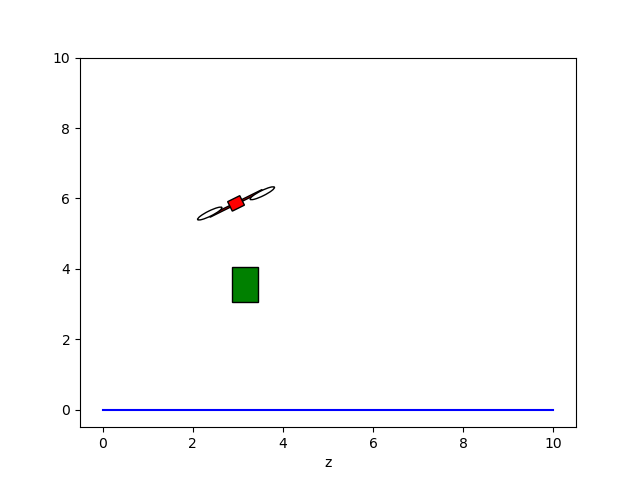

In [4]:
### Fixed Arrival Time - Animation
plt.rcParams["animation.html"] = "jshtml"

n = int((P.tf-P.t0)/P.Ts)
def getTime(i):
    return P.t0 + i * P.Ts

# Get inputs to system (will come from optimization)
inputs = list()
for i in range(n):
    inputs.append([sol[F[i]], sol[tau[i]]])
    
# Simulation + Animation
vtol = None
animation = vtolAnimation()
animation.addObstacles(obstacles)

def animate(i):
    global vtol
    if i == 0:
        vtol = vtolDynamics()
    vtol.propagateDynamics(inputs[i])
    animation.drawVtol(np.array([sol[z[i]], sol[h[i]], sol[theta[i]]]))
    
ani = matplotlib.animation.FuncAnimation(animation.fig, animate, n, interval=1000*P.Ts)

In [1]:
#### Receding Horizon

import vtolParam as P
from vtolAnimation import vtolAnimation
from vtolDynamics import vtolDynamics
from vtolObstacles import vtolObstacles
from IPython.display import HTML
import numpy as np
from math import sin, cos, pi, sqrt, ceil
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
inf = float('inf')

from pyscipopt import Model

model = Model("VTol")

# Constants
n = 100 # planning horizon
execution_horizon = int(ceil(n/2)) # execution horizon
g = P.g
mAll = P.mc +P.mr +P.ml
d = P.d
I = P.Jc + (P.mr + P.ml)*d**2
deltaT = P.Ts
M = 999
u_max = 20
v_max = 10
theta_max = .5
thetaDot_max = 5
obstacles = [((2,3),(3,4))]
epsilon = .25

# Target Destination
h_final = 6
z_final = 3

# Obstacle
# obstacleGenerator = vtolObstacles(P, [P.zc0, P.h0], [z_final, h_final])
# obstacles = [obstacleGenerator.get_new_random()]

h_curr, z_curr = P.h0, P.zc0
theta_curr = 0
zDot_curr = 0
hDot_curr = 0
thetaDot_curr = 0

# State variables
h = {}
z = {}
theta = {}
hDot = {}
zDot = {}
thetaDot = {}

# Cost variables
dist = {}
obj = {}
# control variables
fl = {}
fr = {}
F = {}
tau = {}
fTot = {}
# switch variables
a1 = {}
a2 = {}
a3 = {}
a4 = {}
# Environment
zmin = obstacles[0][0][0]
hmin = obstacles[0][0][1]
zmax = obstacles[0][1][0]
hmax = obstacles[0][1][1]
zcen = (zmin+zmax)/2
hcen = (hmin+hmax)/2

# path history
h_path = {}
z_path = {}
theta_path = {}
model = {}

# linearization variables
theta_last = 0.0
F_last = g*mAll

i = 0
while (((h_curr-h_final)**2 + (z_curr-z_final)**2) > epsilon):
    model[i] = Model("VTol_"+str(i))
    
    # State variables
    h.clear()
    z.clear()
    theta.clear()
    hDot.clear()
    zDot.clear()
    thetaDot.clear()
    for k in range(i,i+n):
        h[k] = model[i].addVar("h_"+str(k), lb = None)
        z[k] = model[i].addVar("z_"+str(k), lb = None)
        theta[k] = model[i].addVar("theta_"+str(k), lb = None)
        hDot[k] = model[i].addVar("hDot_"+str(k), lb = None)
        zDot[k] = model[i].addVar("zDot_"+str(k), lb = None)
        thetaDot[k] = model[i].addVar("thetaDot_"+str(k), lb = None)

    # control variables
    fl.clear()
    fr.clear()
    F.clear()
    tau.clear()
    fTot.clear()
    for k in range(i,i+n):
        fl[k] = model[i].addVar("fl_"+str(k), lb = None)
        fr[k] = model[i].addVar("fr_"+str(k), lb = None)
        F[k] = model[i].addVar("F_"+str(k), lb = None)
        tau[k] = model[i].addVar("tau_"+str(k), lb = None)
        fTot[k] = model[i].addVar("fTot_"+str(k), lb = None)

    # switch variables
    a1.clear()
    a2.clear()
    a3.clear()
    a4.clear()
    for k in range(i,i+n):
        a1[k] = model[i].addVar("a1_"+str(k), vtype ='B')
        a2[k] = model[i].addVar("a2_"+str(k), vtype ='B')
        a3[k] = model[i].addVar("a3_"+str(k), vtype ='B')
        a4[k] = model[i].addVar("a4_"+str(k), vtype ='B')

    # cost variables
    for k in range(i,i+n):
        dist[k] = model[i].addVar("dist_"+str(k))
        obj[k] = model[i].addVar("obj_"+str(k))
        
    # Environment
    zmin = obstacles[0][0][0]
    hmin = obstacles[0][0][1]
    zmax = obstacles[0][1][0]
    hmax = obstacles[0][1][1]

    # # # # Constraints
    # # Starting values
    model[i].addCons(z[i] == z_curr)
    model[i].addCons(h[i] == h_curr)
    model[i].addCons(theta[i] == theta_curr)
    model[i].addCons(zDot[i] == zDot_curr)
    model[i].addCons(hDot[i] == hDot_curr)
    model[i].addCons(thetaDot[i] == thetaDot_curr)

    # # location
    for k in range(i,i+n):
        model[i].addCons(h[k]+.5*d <= hmin + M * a1[k])
        model[i].addCons(-h[k]+.5*d <= -hmax + M * a2[k])
        model[i].addCons(z[k]+2*d <= zmin + M * a3[k])
        model[i].addCons(-z[k]+2*d <= -zmax + M * a4[k])
        model[i].addCons(a1[k] + a2[k] + a3[k] + a4[k] <= 3)

    # # Dynamics
    for k in range(i,i+n-1):
        model[i].addCons(h[k+1] == h[k] + hDot[k]*deltaT)
        model[i].addCons(hDot[k+1] == hDot[k] + (fl[k]+fr[k])/mAll*deltaT)
        model[i].addCons(z[k+1] == z[k] + zDot[k]*deltaT)
        model[i].addCons(zDot[k+1] == zDot[k] - theta[k]*g*deltaT)
        model[i].addCons(theta[k+1] == theta[k] + thetaDot[k]*deltaT)
        model[i].addCons(thetaDot[k+1] == thetaDot[k] + ((fr[k]-fl[k])*d)/I*deltaT)

    # # control limits
    for k in range(i,i+n):
        model[i].addCons(fl[k] + fr[k] == F[k])
        model[i].addCons(d*(fr[k] - fl[k]) == tau[k])
        model[i].addCons(fl[k]**2 + fr[k]**2 == fTot[k])
        model[i].addCons(fTot[k] <= u_max**2)

    # # theta limit
    for k in range(i,i+n):
        model[i].addCons(theta[k]**2 <= theta_max**2)

    # # velocity limits
    for k in range(i,i+n):
        model[i].addCons(hDot[k]**2 + zDot[k]**2 <= v_max**2)
        model[i].addCons(thetaDot[k]**2 <= thetaDot_max**2)
      
    # # Distance
    for k in range(i,i+n):
        model[i].addCons(dist[k] == ((h[k]-h_final)**2 + (z[k]-z_final)**2))
        model[i].addCons(obj[k] == ((h[k]-hcen)**2 + (z[k]-zcen)**2))


    # Objective and solution
#     model[i].setObjective(dist[(i+1)*n-1] + dist[(i*n)+execution_horizon]) 
    model[i].setObjective(dist[i+n-1]) 
#     model[i].setObjective(dist[(i+1)*n-1] - sum(obj)/n*2) 
    model[i].optimize()

    sol = model[i].getBestSol()
    h_curr = sol[h[i+execution_horizon]]
    z_curr = sol[z[i+execution_horizon]]
    theta_curr = sol[theta[i+execution_horizon]]
    zDot_curr = sol[zDot[i+execution_horizon]]
    hDot_curr = sol[hDot[i+execution_horizon]]
    thetaDot_curr = sol[thetaDot[i+execution_horizon]]
    
    theta_last = theta_curr
    F_last = sol[F[i+execution_horizon]]
    
    for k in range(i,i+execution_horizon):
        if sol[h[k]] < -10 or sol[z[k]] < -10:
            print("INFEASIBLE!!!!!!!")
            i = inf
            break

    if i is inf:
        break
    for k in range(i,i+execution_horizon):
        h_path[k] = sol[h[k]]
        z_path[k] = sol[z[k]]
        theta_path[k] = sol[theta[k]]
    
    i += execution_horizon


for k in range(i):
    print(h_path[k], z_path[k])
    
numSteps = i
#     print(h_curr)
#     print(z_curr)
# print('n:',n)
# print('h_0:', sol[h[0]])
# print('h_N:', sol[h[n-1]])
# print('z_0:', sol[z[0]])
# print('z_f:', sol[z[n-1]])

TypeError: a float is required

<IPython.core.display.Javascript object>


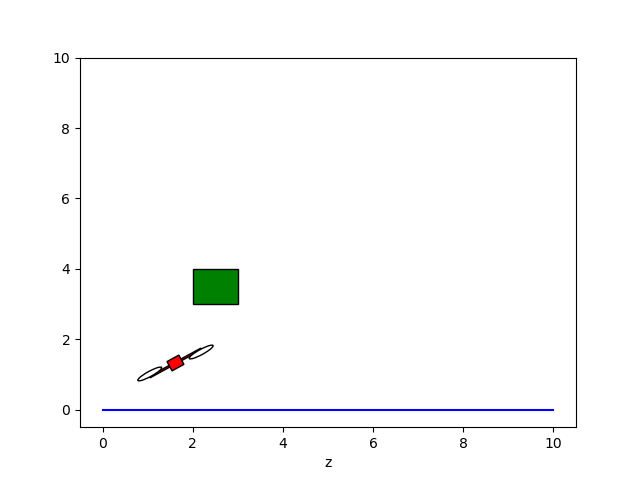

In [8]:
### Receding Horizon - Animation

plt.rcParams["animation.html"] = "jshtml"

n = int((P.tf-P.t0)/P.Ts)
def getTime(i):
    return P.t0 + i * P.Ts

# Simulation + Animation
vtol = None
animation = vtolAnimation()
animation.addObstacles(obstacles)

def animate(i):
    global vtol
    if i == 0:
        vtol = vtolDynamics()
    animation.drawVtol(np.array([z_path[i], h_path[i], theta_path[i]]))
    
ani = matplotlib.animation.FuncAnimation(animation.fig, animate, numSteps, interval=1000*P.Ts)